In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import gammainc as gamma
from scipy.special import iv as I
from scipy.special import factorial
from scipy.signal import unit_impulse as delta
from scipy.stats import ncx2
marcumQ = ncx2.cdf
e = np.exp(1)

# calculate the pdf and look at what kappa does

In [1]:
kap = 0.01 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 1.0
    
def p(x,t,kap=kap,k1=k1,k2=k2,v=v):
    t = t.astype('float128')
    x = x.astype('float64')
    kp = k1+k2
    tmxv = t-x/v
    the = np.heaviside(tmxv,1)
    tmxv[tmxv<=0]=0.0
    a = e**(-(kap+k1)*tmxv-k2*x/v)
    b = 1/v*np.sqrt(k1*k2*x/v/tmxv)*the*I(1,2*np.sqrt(k1*k2*x/v*tmxv))
    c = k2/v*the*I(0,2*np.sqrt(k1*k2*x/v*tmxv))
    d = kap*k2/v/(kap+k1)*the*e**(-k2*x/v)

    def P1(x,y):
        # this is the sum over incomplete gamma functions
        n = 150 # number of terms to keep in Q
        j = np.arange(n).reshape(-1,1).astype('float64')    
        Q = x**j/factorial(j)*gamma(j+1,y)
        return np.nansum(Q,0)
    
    def P1py(x,y):
        # it can also be expressed as a marcum Q-function
        # which is equivalent to a non-central chi-squared cdf
        # this code block provides
        # e^{-x}*\sum_{n=0}^\infty \frac{x^n}{n!n!}\gamma(n+1,y)
        from scipy.stats import ncx2
        Q = ncx2.cdf
        return Q(y*2,df=2,nc=2*x,scale=(x[1]-x[0]))        
    return a*(b+c)+d*e**(k1*k2*x/v/(kap+k1))*P1py( k1*k2*x/v/(kap+k1), (kap+k1)*tmxv)

    

In [5]:
t = np.array([25,75,125])
dx = x[1]-x[0]
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(7,3.5/1.6), dpi=600)

kap = 0.0 
for tt in t:
    ax1.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='black',lw=2)
ax1.set_xlim(0,40)
ax1.set_ylim(0,0.15)
ax1.set_xlabel(r'$x$',fontsize=12)
ax1.set_ylabel(r'$p(x,t)$',fontsize=12)
ax1.set_title(r'Lisle et al. (1998)',fontsize=12)

kap = 0.01 # trapping
for tt in t:
    ax2.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='black',lw=2)
ax2.set_xlim(0,40)
ax2.set_ylim(0,0.15)
ax2.set_xlabel(r'$x$',fontsize=12)
ax2.set_title(r'Trapping model',fontsize=12)

fig.savefig('../grl/figures/pdf-plot.png', bbox_inches='tight')

NameError: name 'x' is not defined

# calculate the mean

In [6]:
def mean(t,k1,k2,kap,v):
    sinh=np.sinh
    cosh=np.cosh
    exp=np.exp
    sqrt = np.sqrt

    kp = k1+k2
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    print(b)
    t = np.float128(t)
    out = 1/b*exp(-a*t)*sinh(b*t)
    out += (kap+k1)/(2*b)*(1/(b-a)*(exp((b-a)*t)-1)+1/(a+b)*(exp(-(a+b)*t)-1))
    return v*out

514.5291536929661


/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


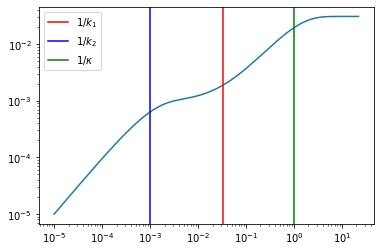

In [20]:
t = np.geomspace(1e-5,1e3,50000)
k1 = 30.0 # inverse rest time
k2 = 1000.0 # inverse motion time
kap = 1
#k1 = k1*10
#k2 = k2*10
#kap = kap*10
v=1
plt.loglog(t,mean(t,k1,k2,kap,v))
plt.axvline(1/k1,label=r'$1/k_1$',color='red')
plt.axvline(1/k2,label=r'$1/k_2$',color='blue')
plt.axvline(1/kap,label=r'$1/\kappa$',color='green')
plt.legend()

# calculate the mean and variance

In [281]:
t = np.geomspace(1e-3,1e6,50000)
motion = 1.0
rest = 1e2
trap = 1e5
k1 = 1/rest
k2 = 1/motion
kap = 1/trap
v=0.5

def cumulants(t,flag,k1,k2,kap,v):
    """ this provides the expressions """
    kp = k1 + k2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(1+(kap+k1)/(b-a))
    B1 = v/(2*b)*(-1+(kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(kap+k1)
    def A2(t):
        out = b+(b-a)*(b*t-1)+2*(kap+k1)*(b*t-1)
        out += (kap+k1)**2/(a-b)**2*(-a*b*t+a+b*(b*t-2))
        return v**2/(2*b**3)*out
    def B2(t):
        out = b-(a+b)*(b*t+1)+2*(kap+k1)*(b*t+1)
        out += -(kap+k1)**2/(a+b)**2*(b*t*(a+b)+a+2*b)
        return v**2/(2*b**3)*out
    C2 = v**2/(2*b**3)*(kap+k1)**2*((a+2*b)/(a+b)**2 + (-a+2*b)/(a-b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out

Text(0.5, 1.0, 'mean')

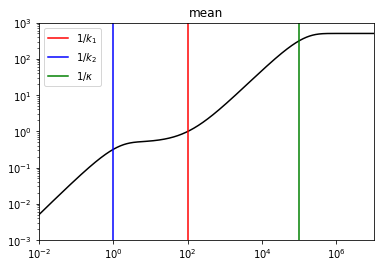

In [282]:

plt.loglog(t,cumulants(t,1,k1,k2,kap,v),color='black')
plt.axvline(1/k1,label=r'$1/k_1$',color='red')
plt.axvline(1/k2,label=r'$1/k_2$',color='blue')
plt.axvline(1/kap,label=r'$1/\kappa$',color='green')
plt.legend()
plt.ylim(1e-3,1e3)
plt.xlim(1e-2,1e7)
plt.title('mean')

(1e-07, 10000000.0)

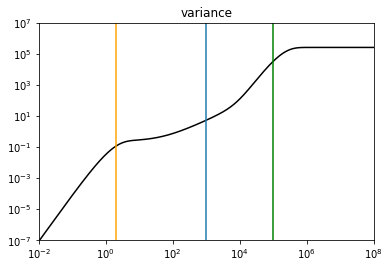

In [298]:
kp = k1+k2
a = (kap+kp)/2.0
b = np.sqrt(a**2-kap*k2)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='black')

om = (kap+k1)/k1
#plt.axvline(1/om,color='purple')
plt.axvline(1/a,color='orange')
plt.axvline(1/kap,color='green')
#plt.axvline(1/kap+kp/k2,color='red')

plt.axvline(k1*k2/kap)
#plt.axvline(1/kp,color='red')
plt.title('variance')
plt.xlim(1e-2,1e8)
plt.ylim(1e-7,1e7)

# make a plot of einstein/lisle/new

In [128]:
# code to plot individual trajecctories of einstein

def einwalk(k1=2.0,k2=1.0,dt=1e-2,tmax=10):
    X = []
    T = []
    t = 0.0
    x = 0.0
    tau = np.random.exponential(1/k1)
    while t<tmax:
        T.append(t)
        t = t + dt
        if t<tau:
            X.append(x)
        else:
            tau += np.random.exponential(1/k1)
            x = x + np.random.exponential(1/k2)
            X.append(x)        
    return T[:-1],X[:-1]

In [136]:
# code to plot lisle1998

# first code up the lisle process from any initial conditions
def walkit(k0=1.0,k1=1.0,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    """
    k0 is the inverse mean resting time
    k1 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta0 is the probability of starting at rest
    theta1 is the probability of starting in motion
    """
    S = []
    T = []
    s = int(np.random.random() > theta0) # initial state
    t = 0.0 # initial time
    T.append(t)
    S.append(s)
    while t<tmax:
        if s==0:
            t = t + np.random.exponential(1/k0)
            S.append(s)            
            s = 1 
            T.append(t)
        elif s==1:
            t = t + np.random.exponential(1/k1)
            S.append(s)            
            s = 0
            T.append(t)
    return np.array(T),np.array(S)

def plotit(walk):
    t,s = walk
    widths = np.diff(t)
    plt.bar(t[:-1],s[:-1]+1,width=widths,edgecolor='black',facecolor='purple',align='edge',zorder=-1)
    
def dispit(walk,ts,v=1.0):
    t,xs = walk
    i = np.searchsorted(t,ts,side='left')
    xs = xs[i]
    dt = ts[1]-ts[0]
    xs = (xs*v*dt).cumsum()
    return xs

In [205]:
# first code up the lisle process from any initial conditions
def walkit2(kap,k0=1.0,k1=1.0,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    """
    k0 is the inverse mean resting time
    k1 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta0 is the probability of starting at rest
    theta1 is the probability of starting in motion
    """
    S = []
    T = []
    s = int(np.random.random() > theta0) # initial state
    t = 0.0 # initial time
    T.append(t)
    S.append(s)
    while t<tmax:
        if s==0:
            dt =  np.random.exponential(1/k0)
            t = t + dt
            if np.exp(-kap*dt)<np.random.random():
                S.append(s)
                T.append(t)
                s = -1
                S.append(-1)
                t= tmax
                T.append(t)
                S.append(-1)
                break
            else:
                S.append(s)
                s = 1 
                T.append(t)
        elif s==1:
            t = t + np.random.exponential(1/k1)
            S.append(s)            
            s = 0
            T.append(t)
    return np.array(T),np.array(S)

def plotit2(walk):
    t,s = walk
    widths = np.diff(t)
    plt.bar(t[:-1],s[:-1]+1,width=widths,edgecolor='black',facecolor='purple',align='edge',zorder=-1)
    
def dispit2(walk,ts,v=1.0):
    t,xs = walk
    i = np.searchsorted(t,ts,side='left')
    xs = xs[i]
    xs[xs==-1]=0
    dt = ts[1]-ts[0]
    xs = (xs*v*dt).cumsum()
    return xs

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:63: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:64: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


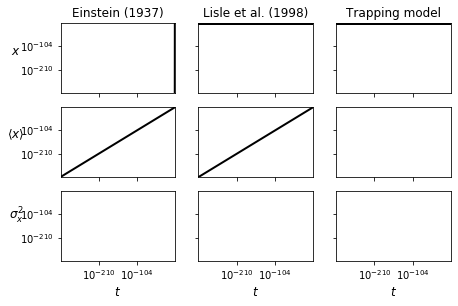

In [263]:
# initialize the figure
fig, axes = plt.subplots(nrows=3,ncols=3, sharex=True,sharey=True, figsize=(7,7/1.6))#, dpi=600)


### FIRST ROW #####
# plot the einstein results
tmax = 100.0
dt = 1e-2
k1 = 1/2# inverse rest time
k2 = 1 # inverse step distance
t = np.arange(0,tmax,dt)
for i in range(5):
    axes[0,0].plot(*einwalk(k1=k1,k2=k2,dt=dt,tmax=20),color='black',lw=2)
# plot the lisle results
for i in range(5):
    v = 1 # velocity
    k2 = k2/v
    walk = walkit(k0=k1,k1=k2,tmax=20,v=v,theta0=0,theta1=1)
    tm = walk[0].max()
    ts = np.arange(0,tm,1e-3)
    xs = dispit(walk,ts)
    axes[0,1].plot(ts,xs,color='black',lw=2)
# plot the new results
for i in range(5):
    kap = 1/5.0
    v = 1 # velocity
    walk = walkit2(kap=kap, k0=k1,k1=k2,tmax=20,v=v,theta0=0,theta1=1)
    tm = walk[0].max()
    ts = np.arange(0,tm,1e-3)
    xs = dispit2(walk,ts)
    axes[0,2].plot(ts,xs,color='black',lw=2)
    
    
#### SECOND ROW #####
# einstein
k1 = 1/2# inverse rest time
k2 = 1 # inverse step distance
def einmean(t):
    return k2/k1*t
axes[1,0].loglog(t,einmean(t),color='black',lw=2)

# lisle
v = 1 # velocity
k2 = k2/v
kap = 1e-9
axes[1,1].loglog(t,cumulants(t,1,k1,k2,kap,v),color='black',lw=2)
# new

# set the xlabels
axes[2,0].set_xlabel(r'$t$',fontsize=12)
axes[2,1].set_xlabel(r'$t$',fontsize=12)
axes[2,2].set_xlabel(r'$t$',fontsize=12)
# ylabels 
axes[0,0].set_ylabel(r'$x$',fontsize=12,rotation=0)
axes[1,0].set_ylabel(r'$\langle x \rangle$',fontsize=12,rotation=0)
axes[2,0].set_ylabel(r'$\sigma_x^2$',fontsize=12,rotation=0)
# titles
axes[0,0].set_title('Einstein (1937)',fontsize=12)
axes[0,1].set_title('Lisle et al. (1998)',fontsize=12)
axes[0,2].set_title('Trapping model',fontsize=12)
# set the xlims on the first row
for ax in axes[:,0]:
    ax.set_ylim(0,10)
    ax.set_xlim(0,20)
# set the xlims on the second row
#for ax in axes[:,1]:
    #ax.set_ylim(1e-3,1)
    #ax.set_xlim(1e-3,10)

# simulate the trapping process

In [300]:
t = np.geomspace(1e-3,1e6,50000)
motion = 1.0
rest = 1e2
trap = 1e5
k1 = 1/rest
k2 = 1/motion
kap = 1/trap
v=0.5
walk = walkit2(kap=kap, k0=k1,k1=k2,tmax=1e6,v=v,theta0=0,theta1=1)
tm = walk[0].max()
ts = np.arange(0,tm,1e-3)
xs = dispit2(walk,ts)

KeyboardInterrupt: 

In [15]:
def A1(kap):
    kp = k1+k2
    a = (kap+kp)/2.0
    b = np.sqrt(a**2-kap*k2)
    #plt.plot(kap,A1(kap))    
    return v/(2*b)*(1+(kap+k1)/(b-a))


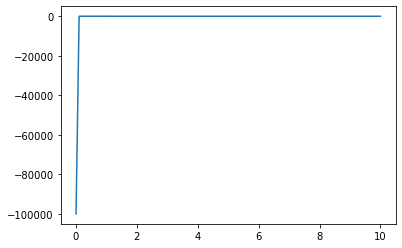

In [17]:
kap = np.linspace(1e-6,10,100)
plt.plot(kap,A1(kap))